## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

print(CWD)
print(os.getcwd())
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray


'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


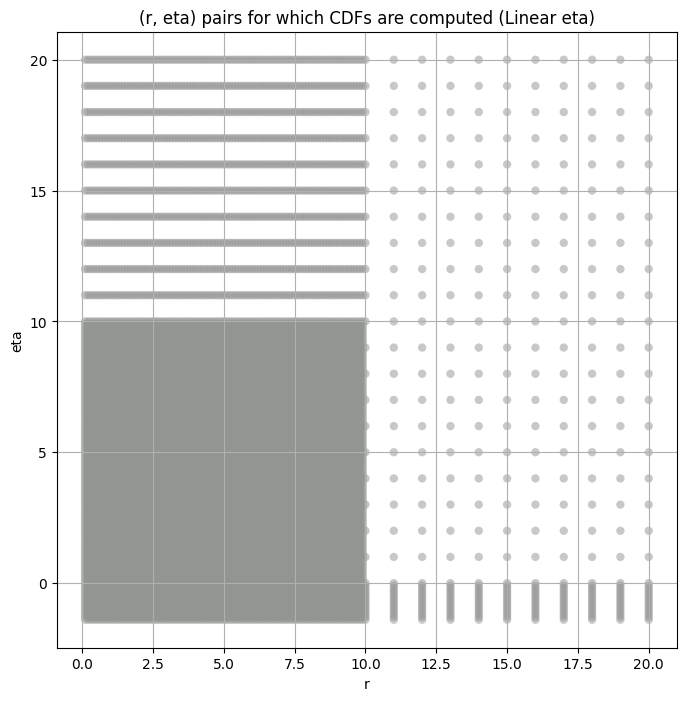

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005503e+07  2.753430e+07  3.270686e+07   0.729729    0.399138   
3      5.664364e+06  5.395078e+06  5.943322e+06   1.467379    1.230193   
4      1.100039e+06  1.039317e+06  1.162902e+06   2.750267    2.308960   
5      2.109552e+05  1.972024e+05  2.252086e+05   4.704251    4.043499   
6      4.082369e+04  3.770970e+04  4.410653e+04   7.281408    6.114861   
7      8.082411e+03  7.363835e+03  8.846996e+03  10.621169    8.625637   
8      1.791217e+03  1.613921e+03  1.979800e+03  13.649155   11.172685   
9      4.776345e+02  4.297178e+02  5.291696e+02  14.632936   11.962647   

       kurt_upper  total_samples  
layer                             
2        1.080607           2446  
3        1.719118           9784  
4        3.245013          39136  
5        5.443361         156544  
6        8.737075         626176  
7       13.356113        2504704  
8       16.721000       10018816  
9       17.944490       40075264

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      3.005503e+07   3.005503e+07    2.518732e+07    2.229941e+07   
3      5.664364e+06   5.664364e+06    5.289866e+06    5.022235e+06   
4      1.100039e+06   1.100039e+06    1.067045e+06    1.042230e+06   
5      2.109552e+05   2.109552e+05    2.072482e+05    2.043072e+05   
6      4.082369e+04   4.082369e+04    3.982486e+04    3.908300e+04   
7      8.082411e+03   8.082411e+03    7.817844e+03    7.632773e+03   
8      1.791217e+03   1.791217e+03    1.724610e+03    1.675689e+03   
9      4.776345e+02   4.776346e+02    4.591505e+02    4.455741e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        2.006750e+07     1.823075e+07     1.515599e+07     1.271654e+07   
3        4.793768e+06     4.593288e+06     4.246996e+06     3.954826e+06   
4        1.021049e+06     1.002424e+06     9.694094e+05     9.403014e+05   
5        2.016594e+05     1.992548e+05     1.949104e+05     1.910150e+05   
6        3.843648e+04     3.784985e+04     3.680139e+04     3.587142e+04   
7        7.473744e+03     7.330624e+03     7.078696e+03     6.857933e+03   
8        1.633840e+03     1.596518e+03     1.531067e+03     1.474319e+03   
9        4.339107e+02     4.235102e+02     4.053020e+02     3.895765e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         1.079439e+07     9.151784e+06     7.786206e+06     4.656465e+06  
3         3.702249e+06     3.481236e+06     3.283898e+06     2.787441e+06  
4         9.138281e+05     8.893434e+05     8.665564e+05     8.058213e+05  
5         1.874294e+05     1.840723e+05     1.809102e+05     1.724098e+05  
6         3.502465e+04     3.424557e+04     3.352081e+04     3.159322e+04  
7         6.659740e+03     6.479214e+03     6.312785e+03     5.878285e+03  
8         1.423877e+03     1.378291e+03     1.336635e+03     1.229410e+03  
9         3.756541e+02     3.631183e+02     3.516884e+02     3.223606e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.058423910478102636 30055032.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.06015260541447137 25187322.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.06825733374514564 22299410.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.07987845938987248 20067502.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.09046119187458712 18230746.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.1100409704423595 15155988.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.12954752963430005 12716535.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1473607666986939 10794388.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.16410587371228869 9151784.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.17979611727596823 7786205.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.229390506041523 4656465.0
Number of samples: 2446, Without approximation : 2446


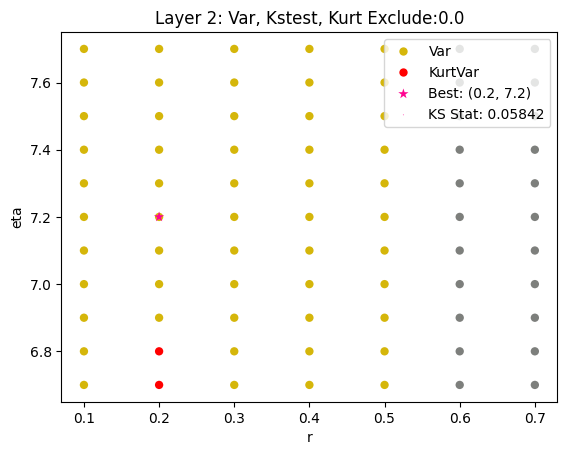

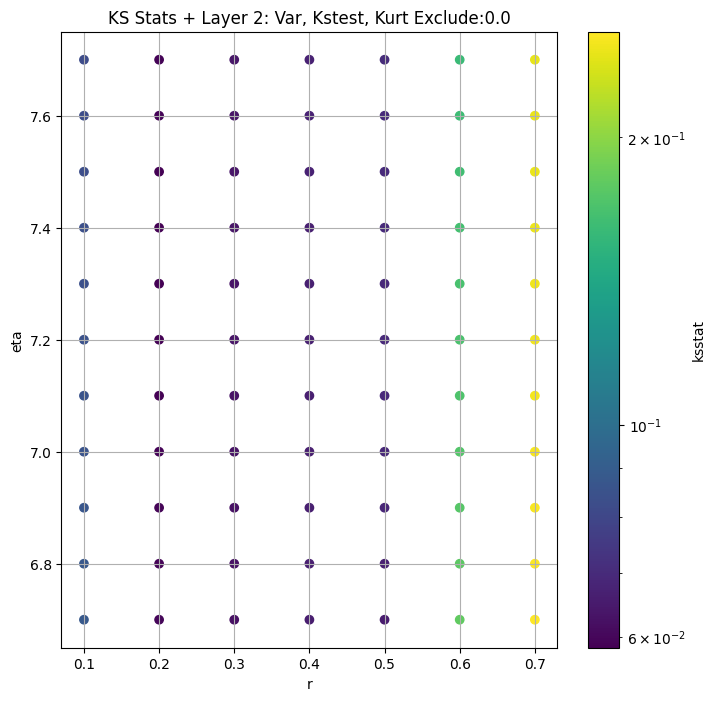

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.04643022374281991 5664363.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.04643985790177929 5289866.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0464874489177039 5022235.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.04651408706073212 4793768.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.047095557238176156 4593288.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.04815352941513951 4246996.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.0501324958847581 3954826.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.052218872911977854 3702248.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05591519242706244 3481235.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06134110853129926 3283898.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.07699278214281025 2787441.0
Number of samples: 9784, Without approximation : 9784


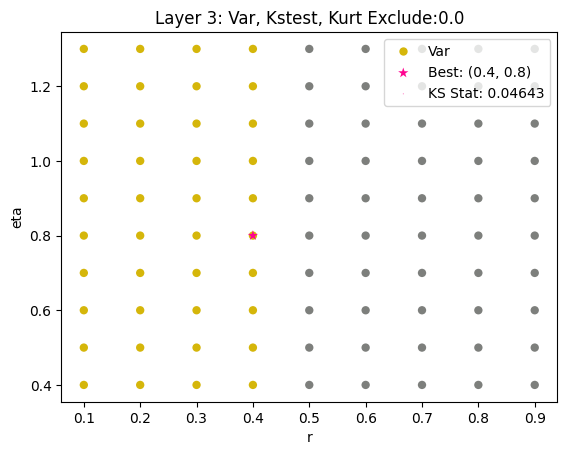

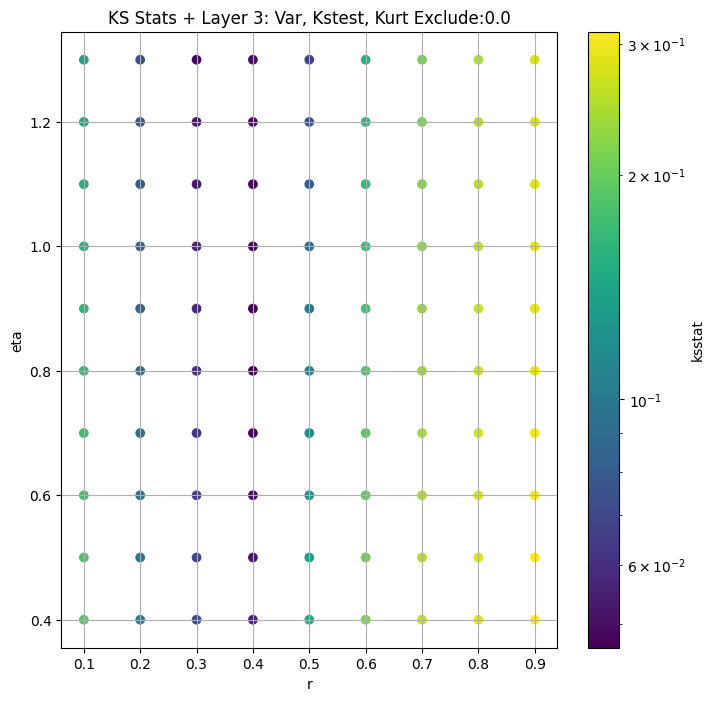

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.032513866464266516 1100038.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.03238851651279784 1067045.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.0319869723680537 1042230.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.032513866464266516 1021049.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.032513866464266516 1002423.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.032513866464266516 969409.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.032513866464266516 940301.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.0337780346510731 913828.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.03408902614817244 889343.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.03429984850279849 866556.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.03677972273384594 805821.3
Number of samples: 39136, Without approximation : 39136


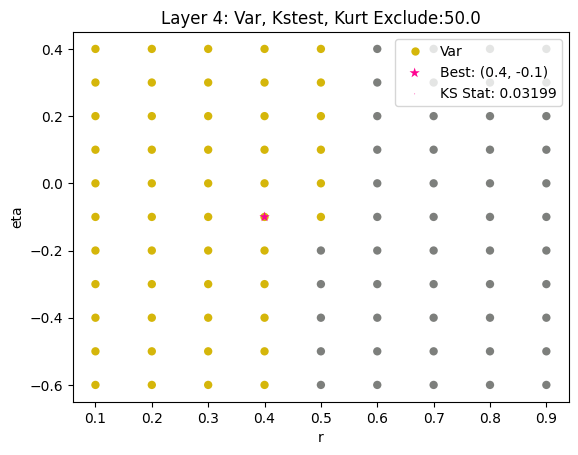

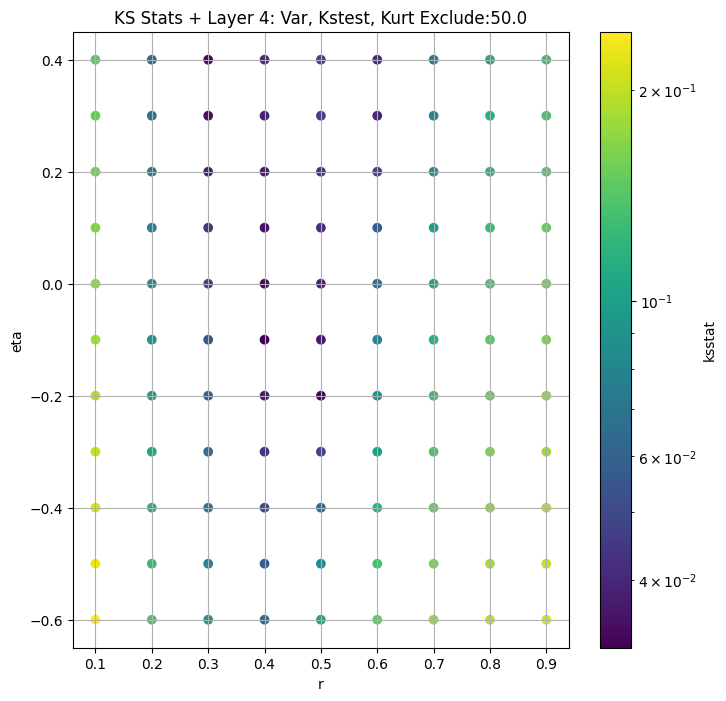

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.025122304288567487 210955.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.025112444016683666 207248.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.025104432584611258 204307.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.02509707188878485 201659.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.02509026176304774 199254.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.025242964884582275 194910.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.025242964884582275 191014.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.025242964884582275 187429.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.025224479245918363 184072.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.025211580474083506 180910.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.025175192668884294 172409.83
Number of samples: 100000, Without approximation : 156544


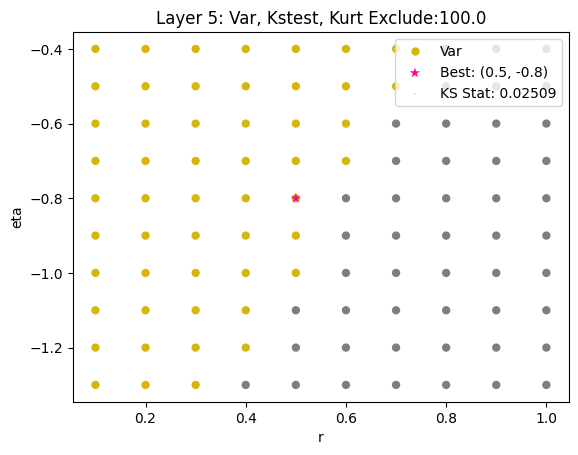

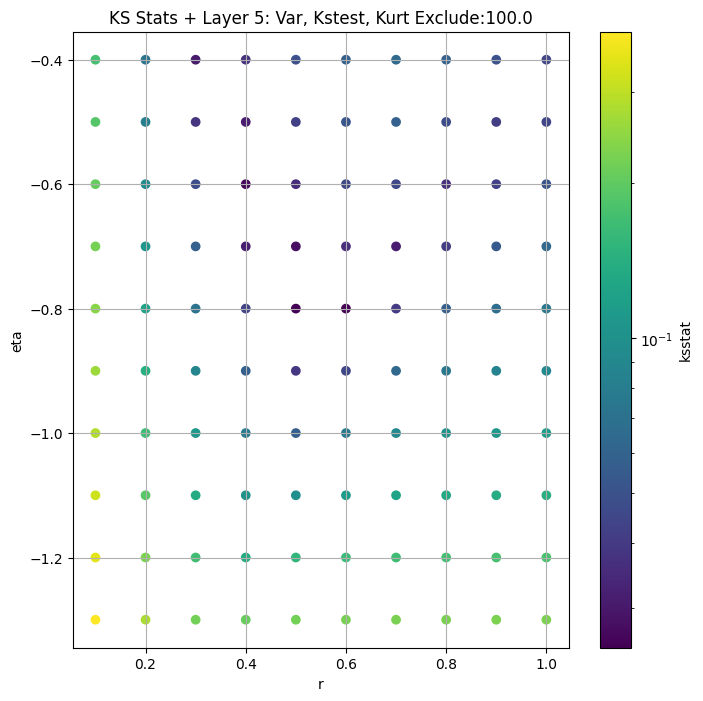

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.026958018736708445 40823.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.0268781414266413 39824.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.027040980534881354 39082.996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.027277761897419706 38436.477


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.027497346852272342 37849.85


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.027901578324894927 36801.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.028273463170120805 35871.418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.027708480800178514 35024.652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.027165470710142137 34245.57


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.027098299311973606 33520.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.026908958119203907 31593.225
Number of samples: 100000, Without approximation : 626176


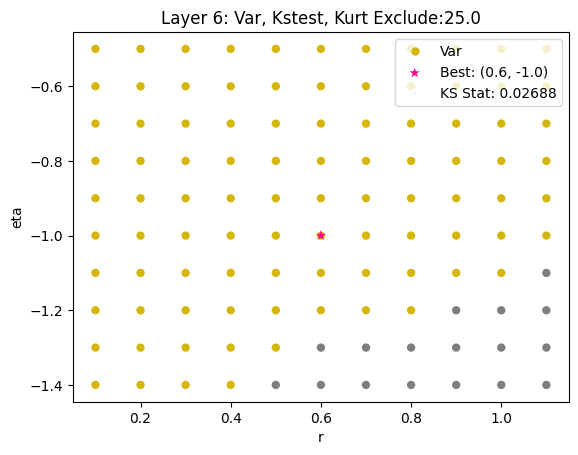

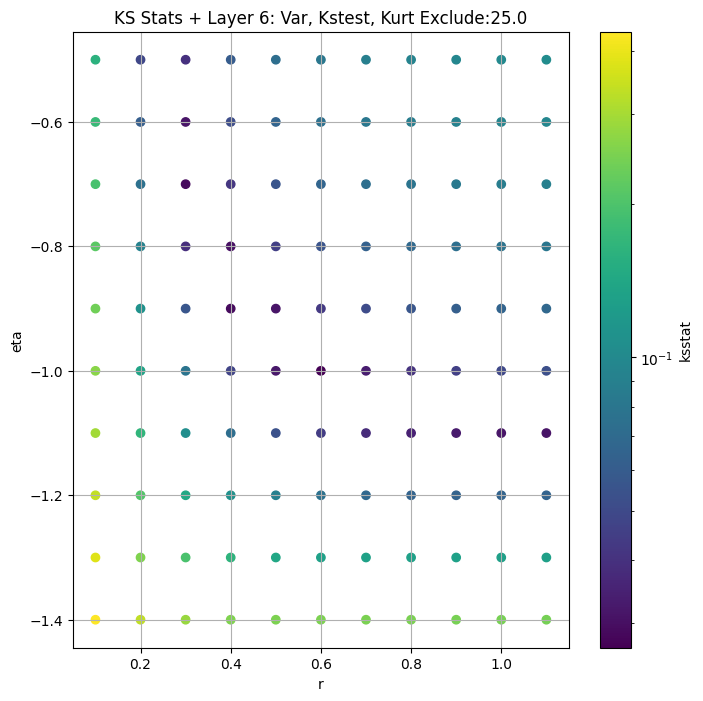

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03039450733486282 8082.4106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.03034115025223688 7817.844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.030166046174547434 7632.7734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.03001093739083699 7473.744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.03020123782604714 7330.624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.030084647723462754 7078.696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.029893967060198312 6857.9326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.029802186355708415 6659.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.02973929303263778 6479.2144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.0298820875034429 6312.7847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.0305452732874113 5878.285
Number of samples: 100000, Without approximation : 2504704


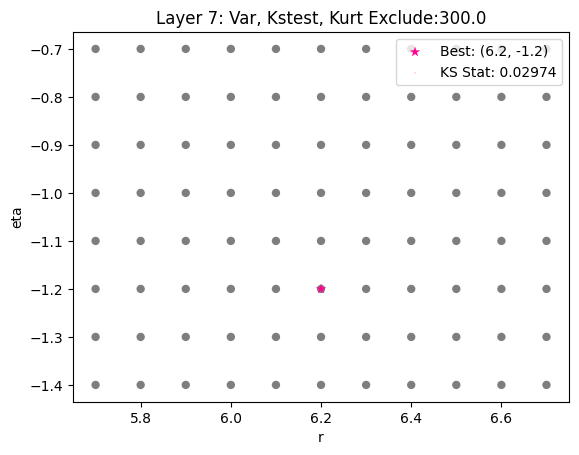

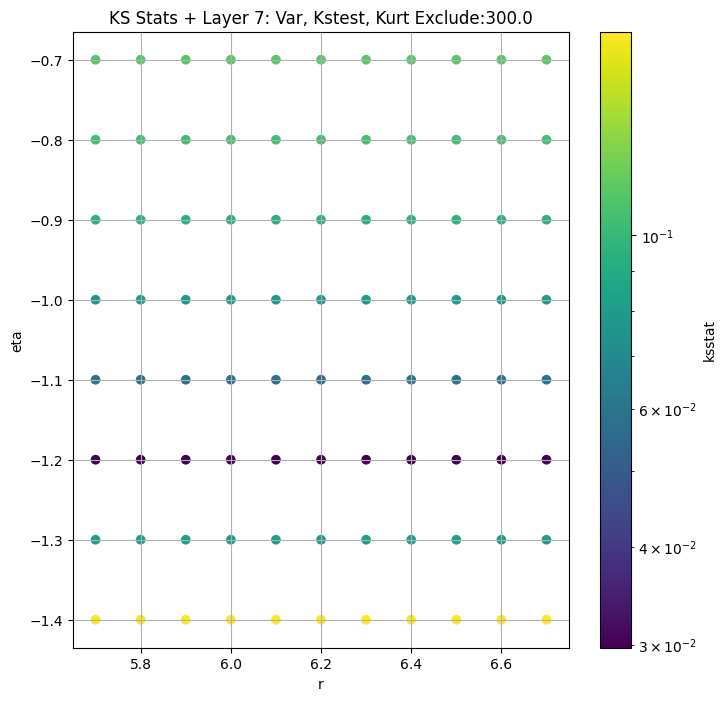

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.014224551832298371 1791.2172


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.012834701418030114 1724.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.013775832237489127 1675.6888


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.014625976841258659 1633.8402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.015416203606537171 1596.518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.015567339299339178 1531.0671


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.015185999415473939 1474.3192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.01483247985102415 1423.877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.013459181850410173 1378.2905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.011748634112250966 1336.6355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.013831765426746023 1229.4098
Number of samples: 100000, Without approximation : 10018816


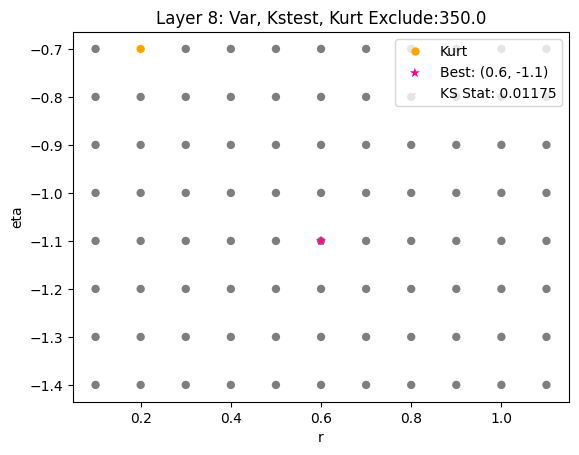

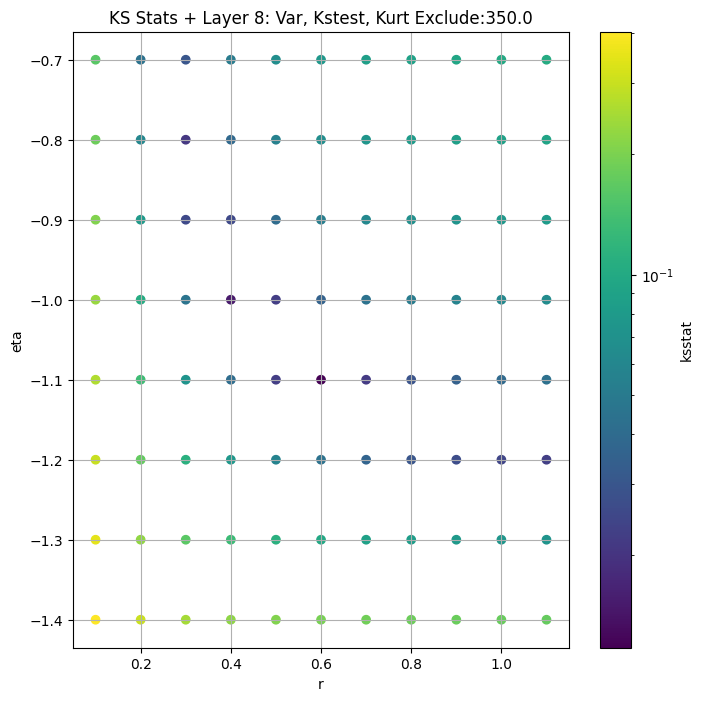

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.01268348292458199 477.63455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013963969289416012 459.15054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.014946580042098256 445.57413


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.016054904619610566 433.9107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.01523634268623747 423.51022


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.013577402130595828 405.30203


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.012073784916518504 389.57654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.010684656398415593 375.65414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.009748215964576479 363.11835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00921750611224137 351.6884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.013487979539680839 322.36057
Number of samples: 100000, Without approximation : 40075264


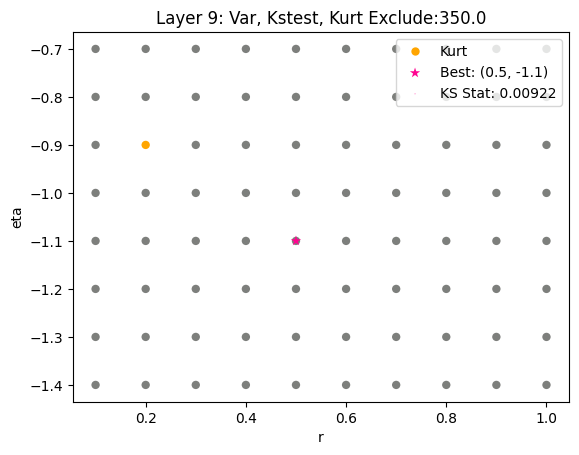

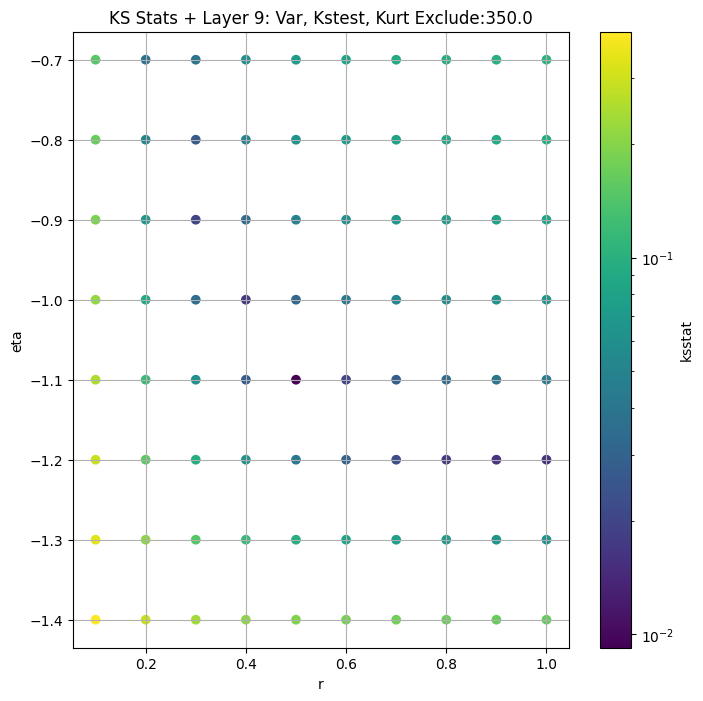

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005503e+07  2.753430e+07  3.270686e+07   0.729729    0.399138   
3      5.664364e+06  5.395078e+06  5.943322e+06   1.467379    1.230193   
4      1.100039e+06  1.039317e+06  1.162902e+06   2.750267    2.308960   
5      2.109552e+05  1.972024e+05  2.252086e+05   4.704251    4.043499   
6      4.082369e+04  3.770970e+04  4.410653e+04   7.281408    6.114861   
7      8.082411e+03  7.363835e+03  8.846996e+03  10.621169    8.625637   
8      1.791217e+03  1.613921e+03  1.979800e+03  13.649155   11.172685   
9      4.776345e+02  4.297178e+02  5.291696e+02  14.632936   11.962647   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.080607           2446             0.058424        0.2          7.2   
3        1.719118           9784             0.046430        0.4          0.8   
4        3.245013          39136             0.031987        0.4         -0.1   
5        5.443361         156544             0.025090        0.5         -0.8   
6        8.737075         626176             0.026878        0.6         -1.0   
7       13.356113        2504704             0.029739        6.2         -1.2   
8       16.721000       10018816             0.011749        0.6         -1.1   
9       17.944490       40075264             0.009218        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.154493                     0.0        3.005503e+07   
3       53275.625964                     0.0        5.664364e+06   
4       28864.140940                    50.0        1.042230e+06   
5       59302.008929                   100.0        1.992548e+05   
6       33816.609448                    25.0        3.982486e+04   
7       29874.353033                   300.0        6.479214e+03   
8        1520.159827                   350.0        1.336636e+03   
9         244.228045                   350.0        3.516884e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.09472717184415291, var: 18230746.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.08442000194367394, var: 20067502.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.07314140990889462, var: 22299410.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.06013073772985861, var: 25187322.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.058423910478102636, var: 30055032.0
Number of samples: 2446, Without approximation : 2446


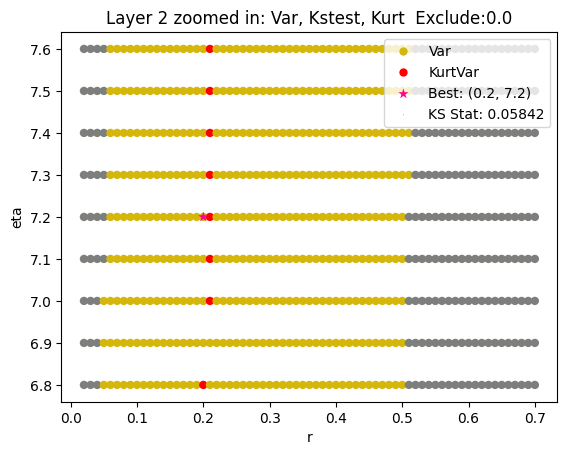

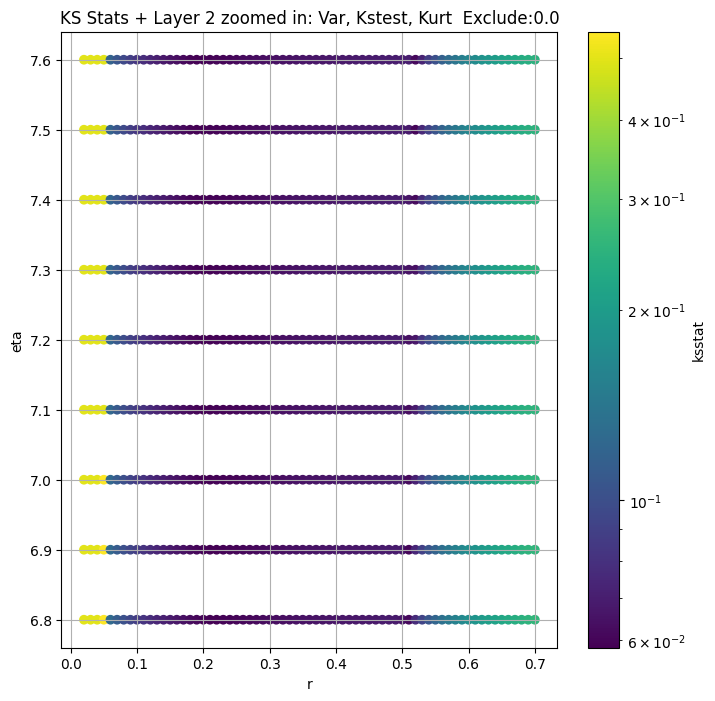

Layer 3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.04788167262544685, var: 4593288.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.04649378009509647, var: 4793768.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.0464874489177039, var: 5022235.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.04643897215229531, var: 5289866.0


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.04641456716100817, var: 5664363.5
Number of samples: 9784, Without approximation : 9784


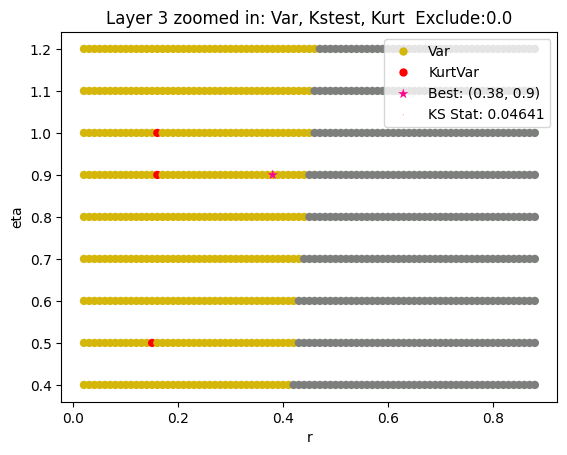

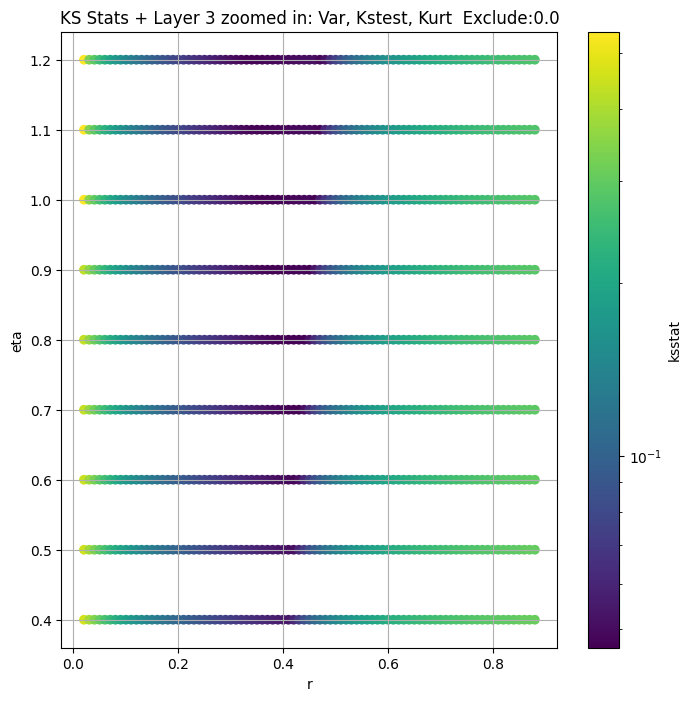

Layer 4


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 100 = 150, ksstat: 0.03201510002226232, var: 969409.375


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 75 = 125, ksstat: 0.03202530635275769, var: 985292.875


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 50 = 100, ksstat: 0.03203916356865011, var: 1002423.8125


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 25 = 75, ksstat: 0.03202170411142491, var: 1021049.375


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 0 = 50, ksstat: 0.031670303628582586, var: 1042230.25


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + -25 = 25, ksstat: 0.03143075506673654, var: 1067045.375


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + -50 = 0, ksstat: 0.031465826697403165, var: 1100038.75
Number of samples: 39136, Without approximation : 39136


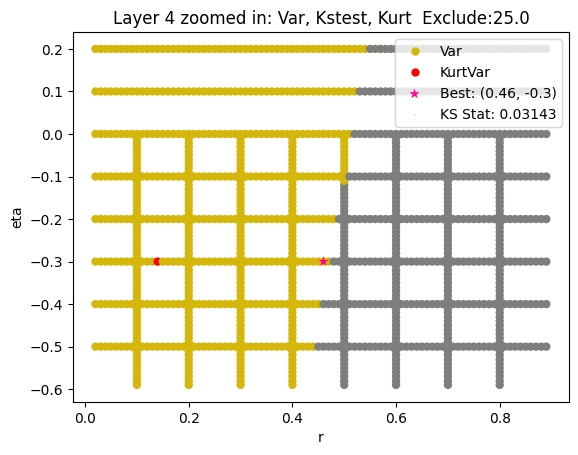

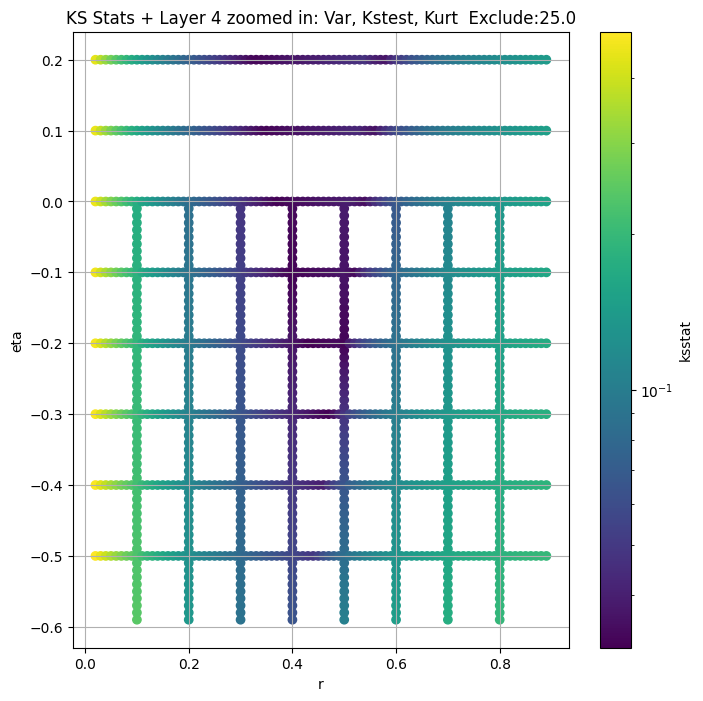

Layer 5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 100 = 200, ksstat: 0.02511766907034302, var: 191014.96875


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 75 = 175, ksstat: 0.0251052695396195, var: 192914.640625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 50 = 150, ksstat: 0.025110949875776944, var: 194910.4375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 25 = 125, ksstat: 0.02509819949103176, var: 197015.234375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 0 = 100, ksstat: 0.02509026176304774, var: 199254.75


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -25 = 75, ksstat: 0.02509707188878485, var: 201659.375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -50 = 50, ksstat: 0.02506911886071639, var: 204307.203125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -75 = 25, ksstat: 0.02503985120148894, var: 207248.25


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -100 = 0, ksstat: 0.02505032603520646, var: 210955.1875
Number of samples: 100000, Without approximation : 156544


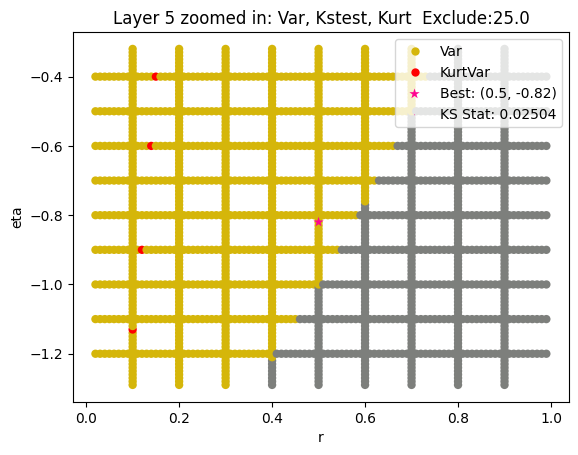

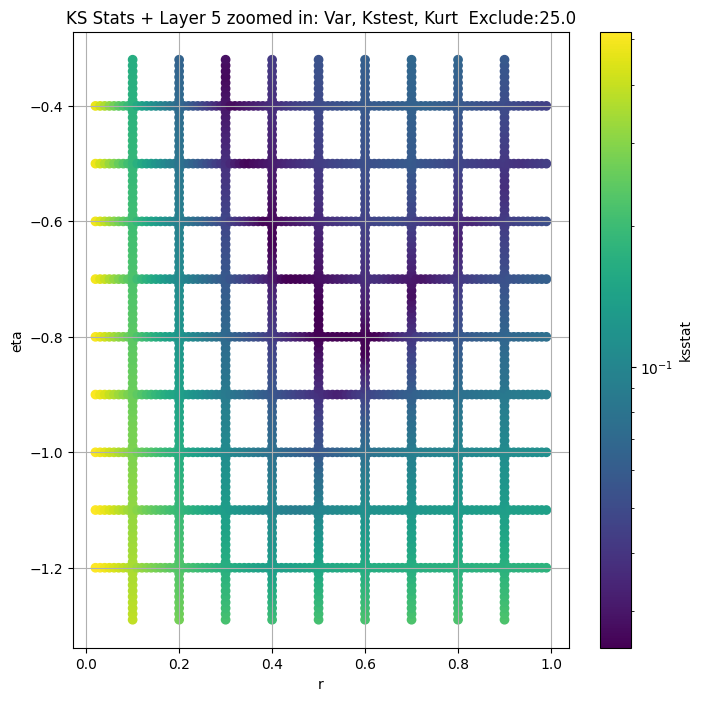

Layer 6


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 100 = 125, ksstat: 0.026797148215403355, var: 37307.90625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 75 = 100, ksstat: 0.026884870481025724, var: 37849.8515625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 50 = 75, ksstat: 0.026909998818598346, var: 38436.4765625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 25 = 50, ksstat: 0.026900963967732505, var: 39082.99609375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 0 = 25, ksstat: 0.0268781414266413, var: 39824.859375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + -25 = 0, ksstat: 0.02685691643650312, var: 40823.69140625
Number of samples: 100000, Without approximation : 626176


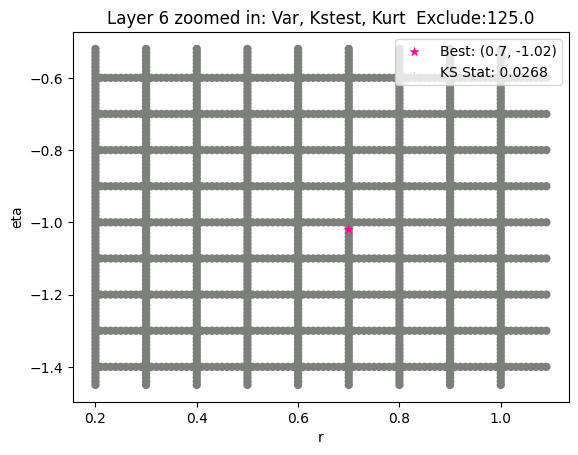

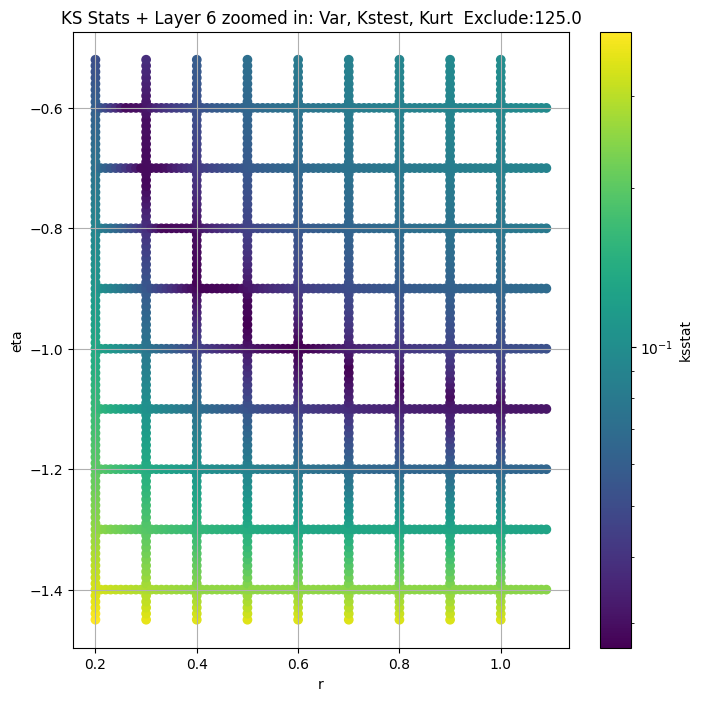

Layer 7


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + 100 = 400, ksstat: 0.02992009315787686, var: 6158.24072265625


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + 75 = 375, ksstat: 0.03060102803604564, var: 6234.18359375


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + 50 = 350, ksstat: 0.03041336376084902, var: 6312.78466796875


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + 25 = 325, ksstat: 0.03004302077128429, var: 6394.373046875


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + 0 = 300, ksstat: 0.02973929303263778, var: 6479.21435546875


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + -25 = 275, ksstat: 0.030349725183244636, var: 6567.47802734375


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + -50 = 250, ksstat: 0.031155817264899688, var: 6659.740234375


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + -75 = 225, ksstat: 0.03198713612033094, var: 6756.39111328125


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 7, 300.0 + -100 = 200, ksstat: 0.03207275073633564, var: 6857.9326171875
Number of samples: 100000, Without approximation : 2504704


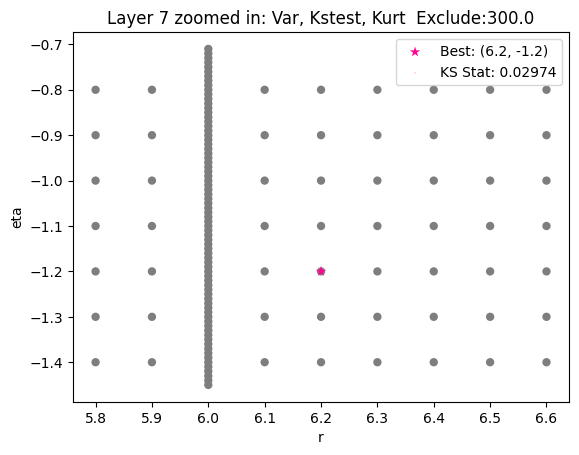

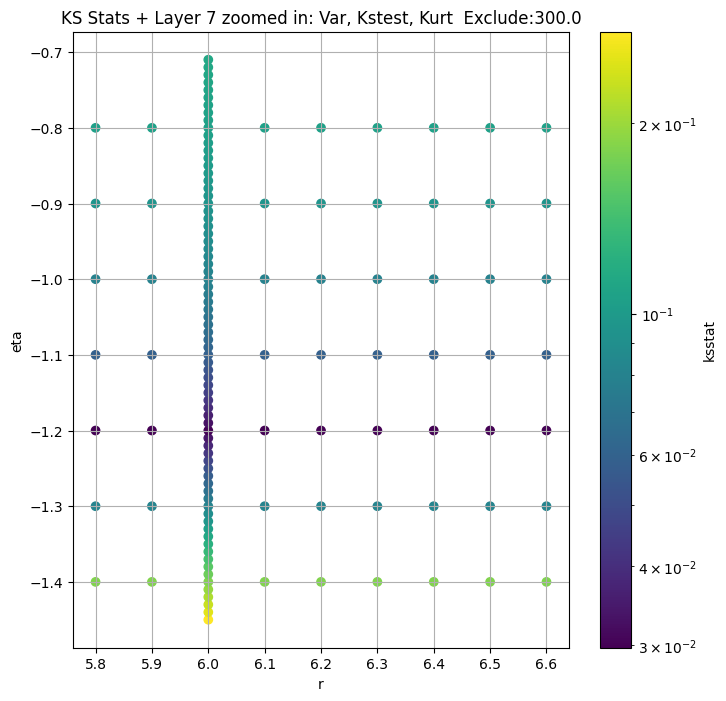

Layer 8


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + 100 = 450, ksstat: 0.011559837411684426, var: 1262.6136474609375


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + 75 = 425, ksstat: 0.01148848932451696, var: 1280.0963134765625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + 50 = 400, ksstat: 0.011557955472738024, var: 1298.2193603515625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + 25 = 375, ksstat: 0.011408315483253106, var: 1317.054931640625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + 0 = 350, ksstat: 0.011748634112250966, var: 1336.635498046875


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + -25 = 325, ksstat: 0.01140588172275403, var: 1357.0245361328125


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + -50 = 300, ksstat: 0.011650931743157344, var: 1378.29052734375


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + -75 = 275, ksstat: 0.01191917479838378, var: 1400.53564453125


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 350.0 + -100 = 250, ksstat: 0.011559141730298594, var: 1423.876953125
Number of samples: 100000, Without approximation : 10018816


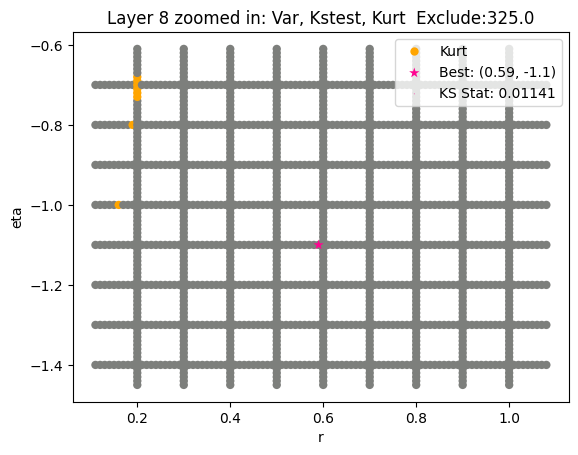

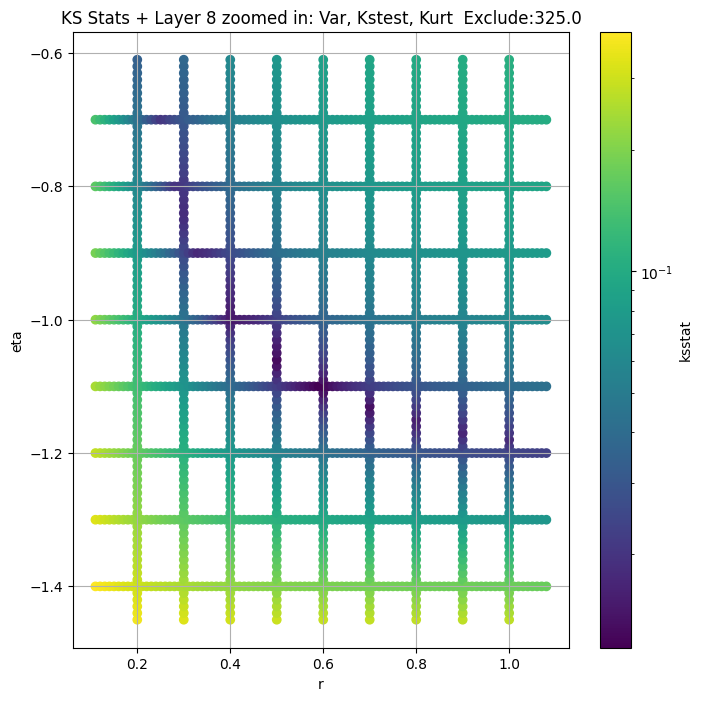

Layer 9


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + 100 = 450, ksstat: 0.01026922566605637, var: 331.4331359863281


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + 75 = 425, ksstat: 0.010104818727858067, var: 336.21441650390625


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + 50 = 400, ksstat: 0.009978459837692966, var: 341.1734619140625


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + 25 = 375, ksstat: 0.009631013475001171, var: 346.3272399902344


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + 0 = 350, ksstat: 0.00921750611224137, var: 351.6883850097656


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + -25 = 325, ksstat: 0.00925984087874765, var: 357.278076171875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + -50 = 300, ksstat: 0.009181882273827213, var: 363.11834716796875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + -75 = 275, ksstat: 0.00927505100198206, var: 369.2318420410156


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 9, 350.0 + -100 = 250, ksstat: 0.009255140500332937, var: 375.6541442871094
Number of samples: 100000, Without approximation : 40075264


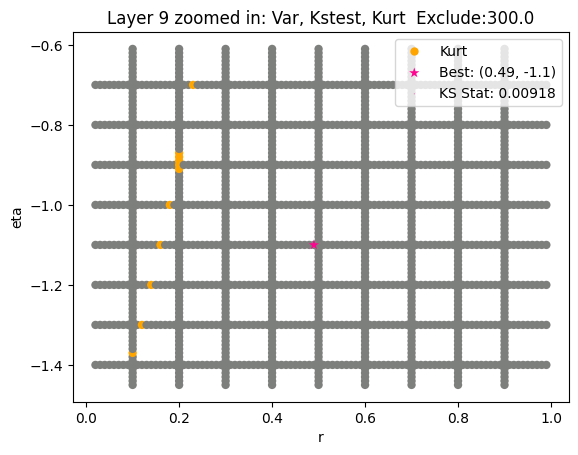

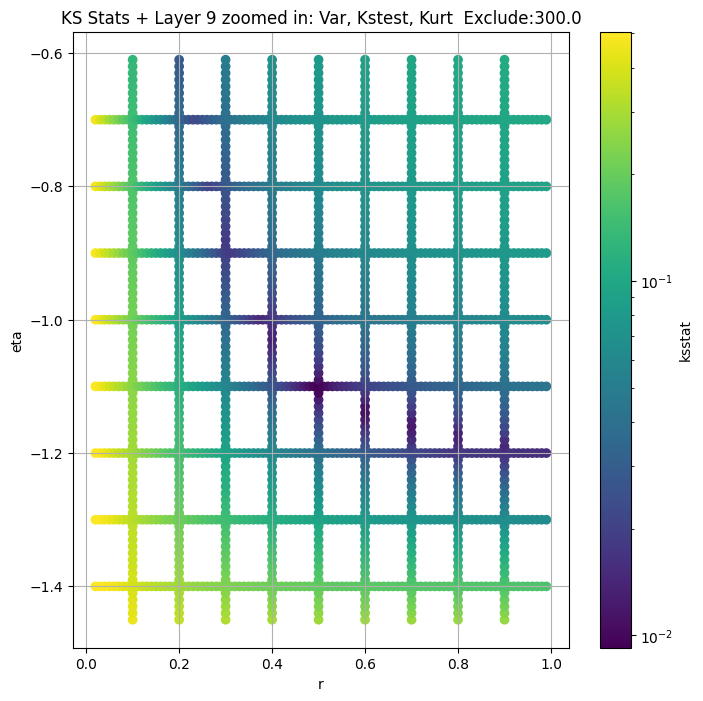

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005503e+07  2.753430e+07  3.270686e+07   0.729729    0.399138   
3      5.664364e+06  5.395078e+06  5.943322e+06   1.467379    1.230193   
4      1.100039e+06  1.039317e+06  1.162902e+06   2.750267    2.308960   
5      2.109552e+05  1.972024e+05  2.252086e+05   4.704251    4.043499   
6      4.082369e+04  3.770970e+04  4.410653e+04   7.281408    6.114861   
7      8.082411e+03  7.363835e+03  8.846996e+03  10.621169    8.625637   
8      1.791217e+03  1.613921e+03  1.979800e+03  13.649155   11.172685   
9      4.776345e+02  4.297178e+02  5.291696e+02  14.632936   11.962647   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.080607           2446             0.058424        0.2          7.2   
3        1.719118           9784             0.046430        0.4          0.8   
4        3.245013          39136             0.031987        0.4         -0.1   
5        5.443361         156544             0.025090        0.5         -0.8   
6        8.737075         626176             0.026878        0.6         -1.0   
7       13.356113        2504704             0.029739        6.2         -1.2   
8       16.721000       10018816             0.011749        0.6         -1.1   
9       17.944490       40075264             0.009218        0.5         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.154493                     0.0        3.005503e+07   
3       53275.625964                     0.0        5.664364e+06   
4       28864.140940                    50.0        1.067045e+06   
5       59302.008929                   100.0        2.072482e+05   
6       33816.609448                    25.0        3.730791e+04   
7       29874.353033                   300.0        6.479214e+03   
8        1520.159827                   350.0        1.357025e+03   
9         244.228045                   350.0        3.631183e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.058424    0.20      7.20   
3                     0.013713          0.046415    0.38      0.90   
4                     0.006861          0.031431    0.46     -0.30   
5                     0.003431          0.025040    0.50     -0.82   
6                     0.001716          0.026797    0.70     -1.02   
7                     0.000858          0.029739    6.20     -1.20   
8                     0.000429          0.011406    0.59     -1.10   
9                     0.000215          0.009182    0.49     -1.10   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2          0.154493                  0.0          513  
3      32622.054278                  0.0          868  
4      88292.649637                 25.0         1834  
5      64571.364033                 25.0         3094  
6      46775.563725                125.0         2446  
7      29874.353033                300.0         2062  
8       1483.493005                325.0        14676  
9        236.490665                300.0        22014

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

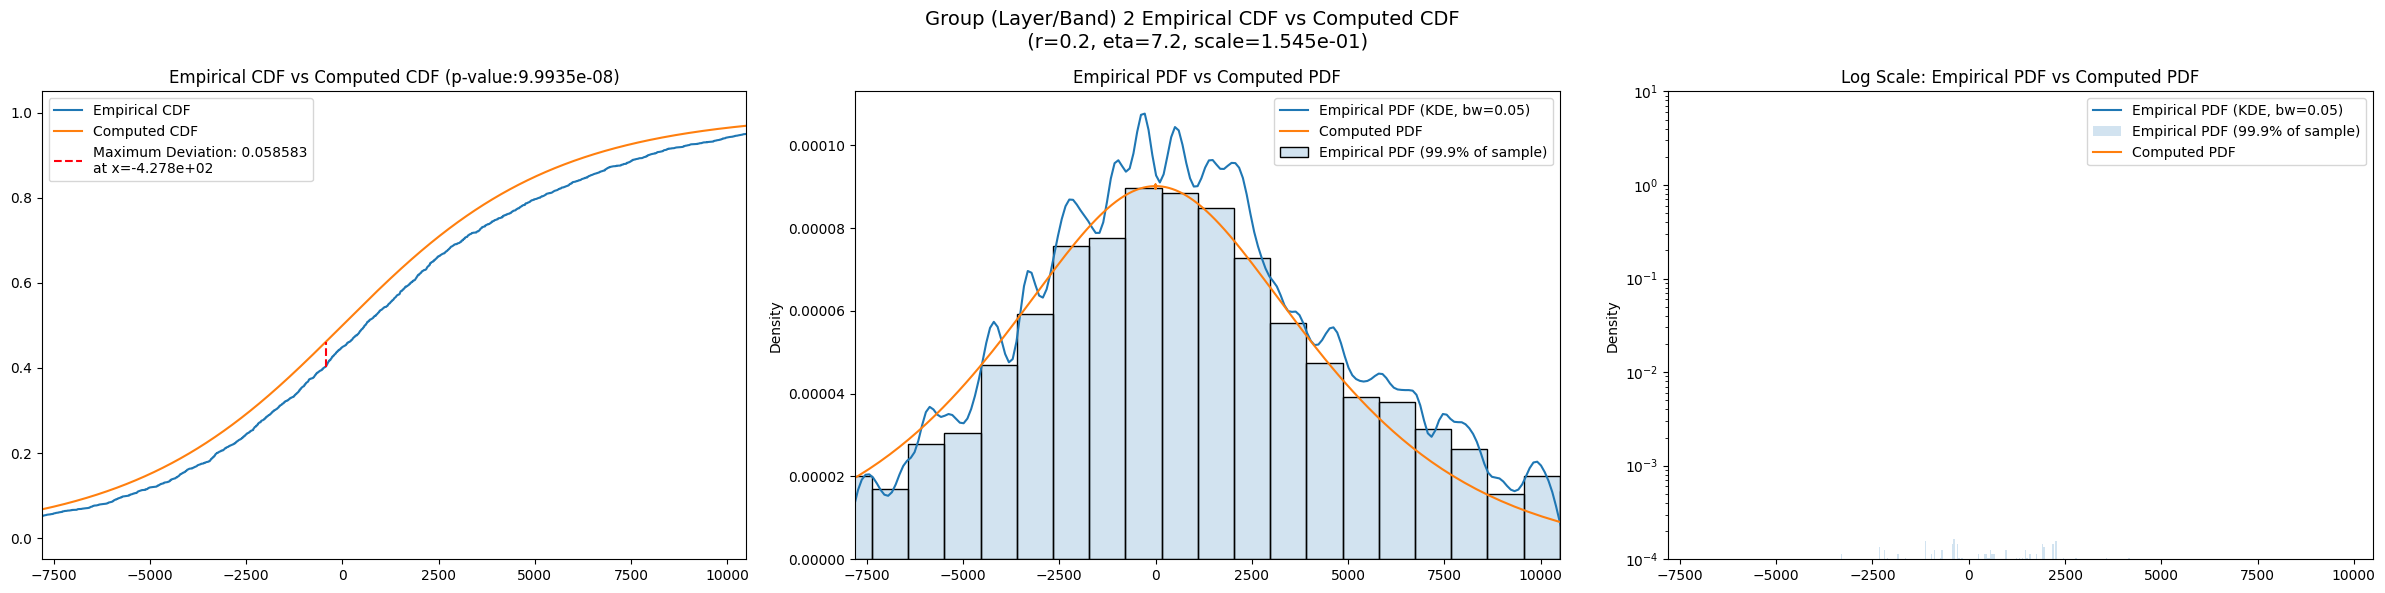

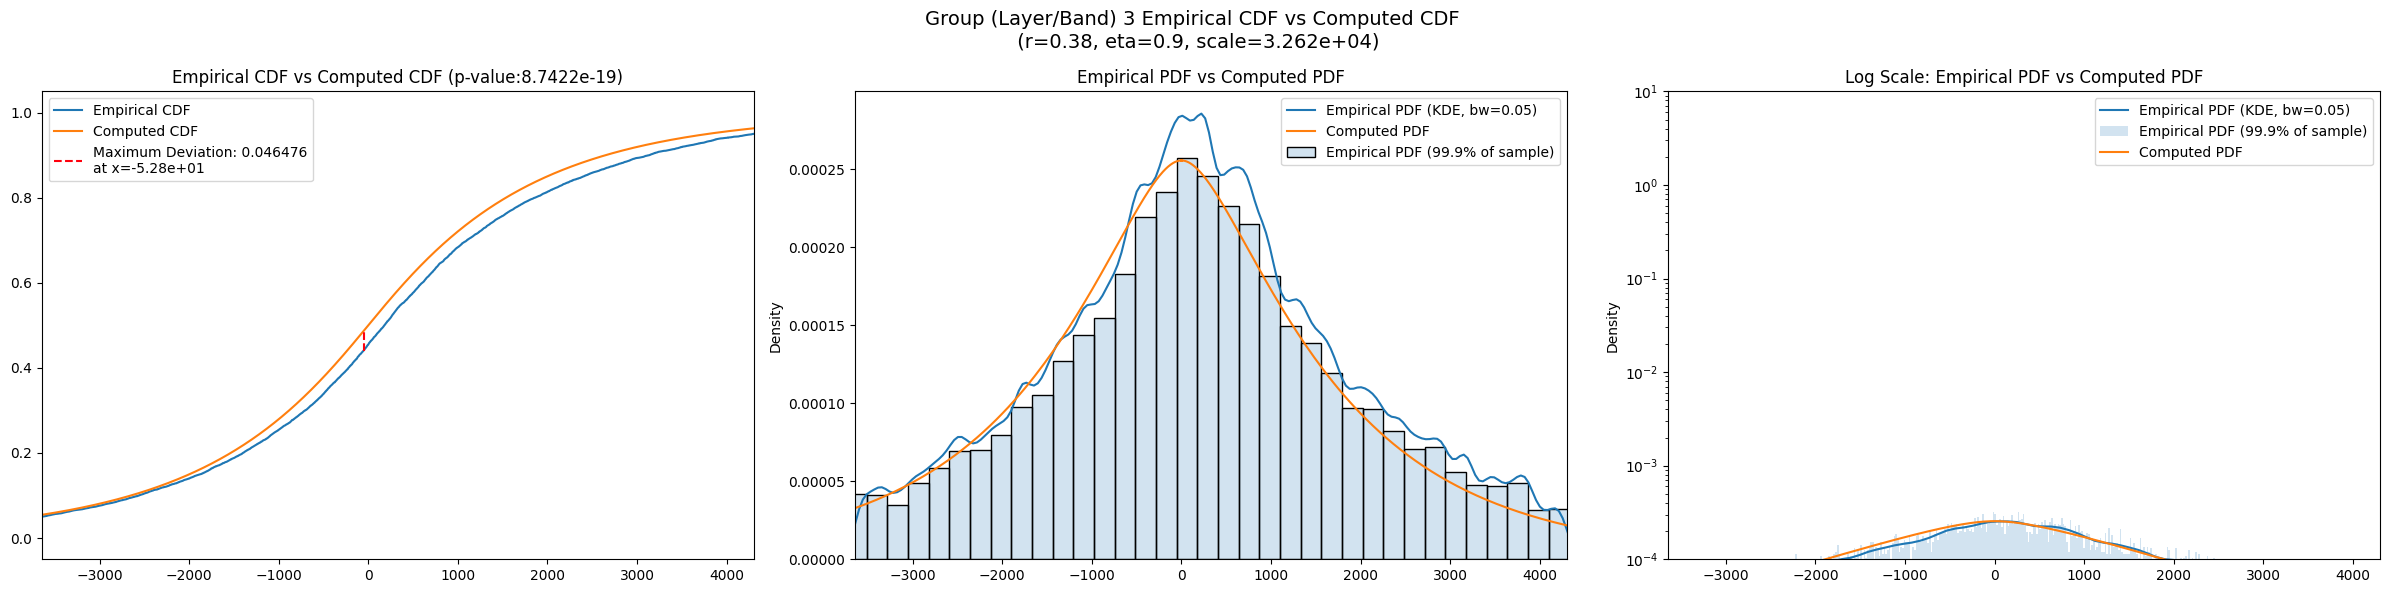

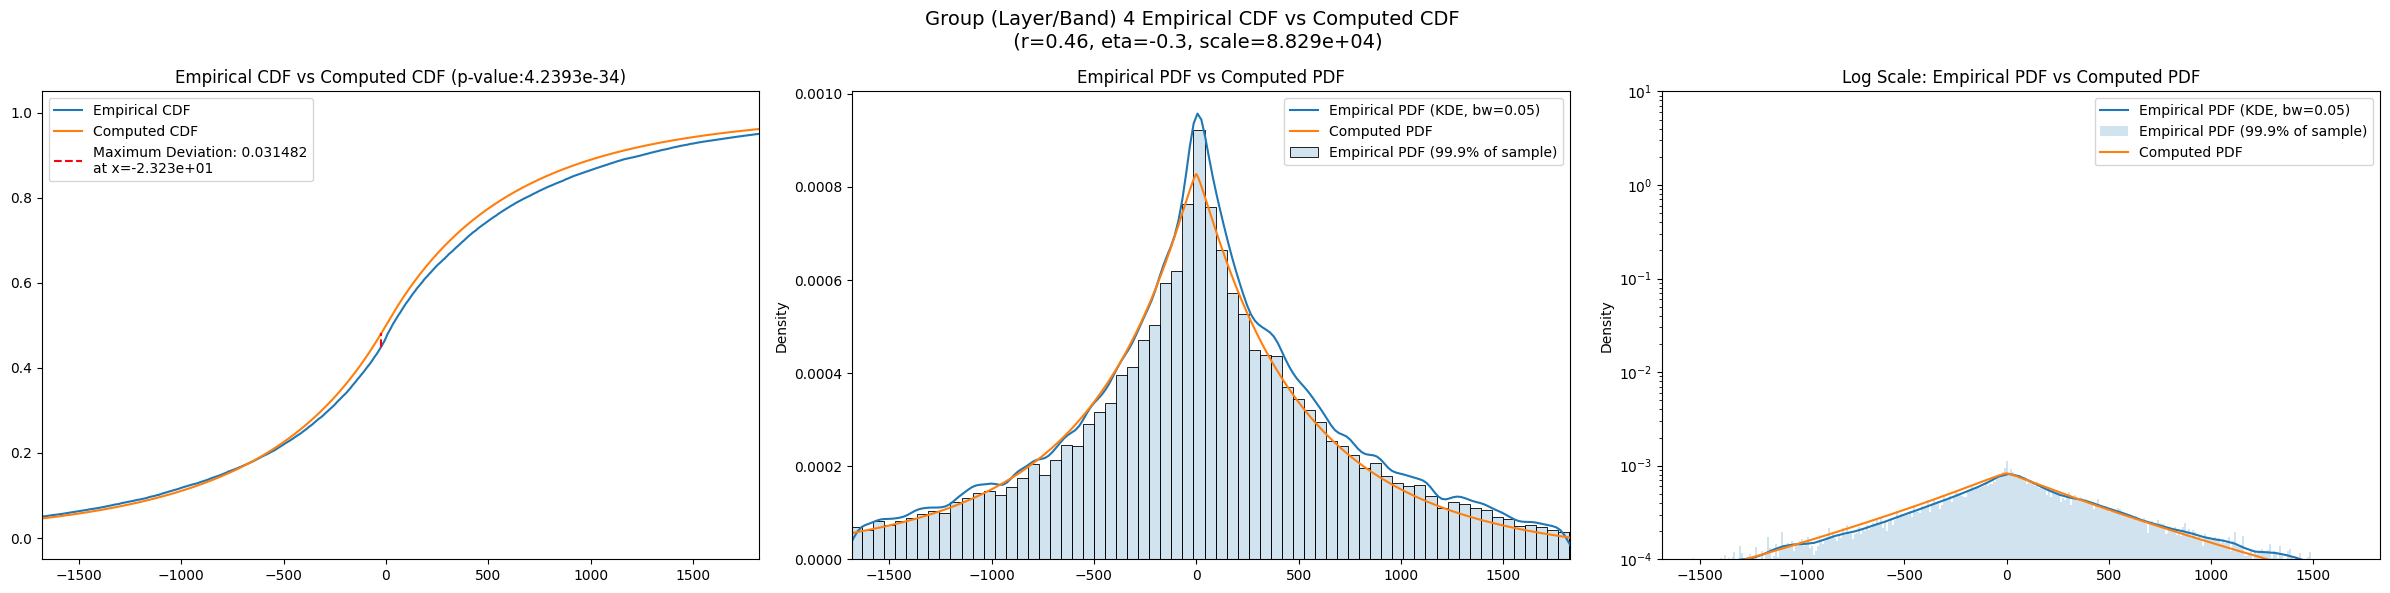

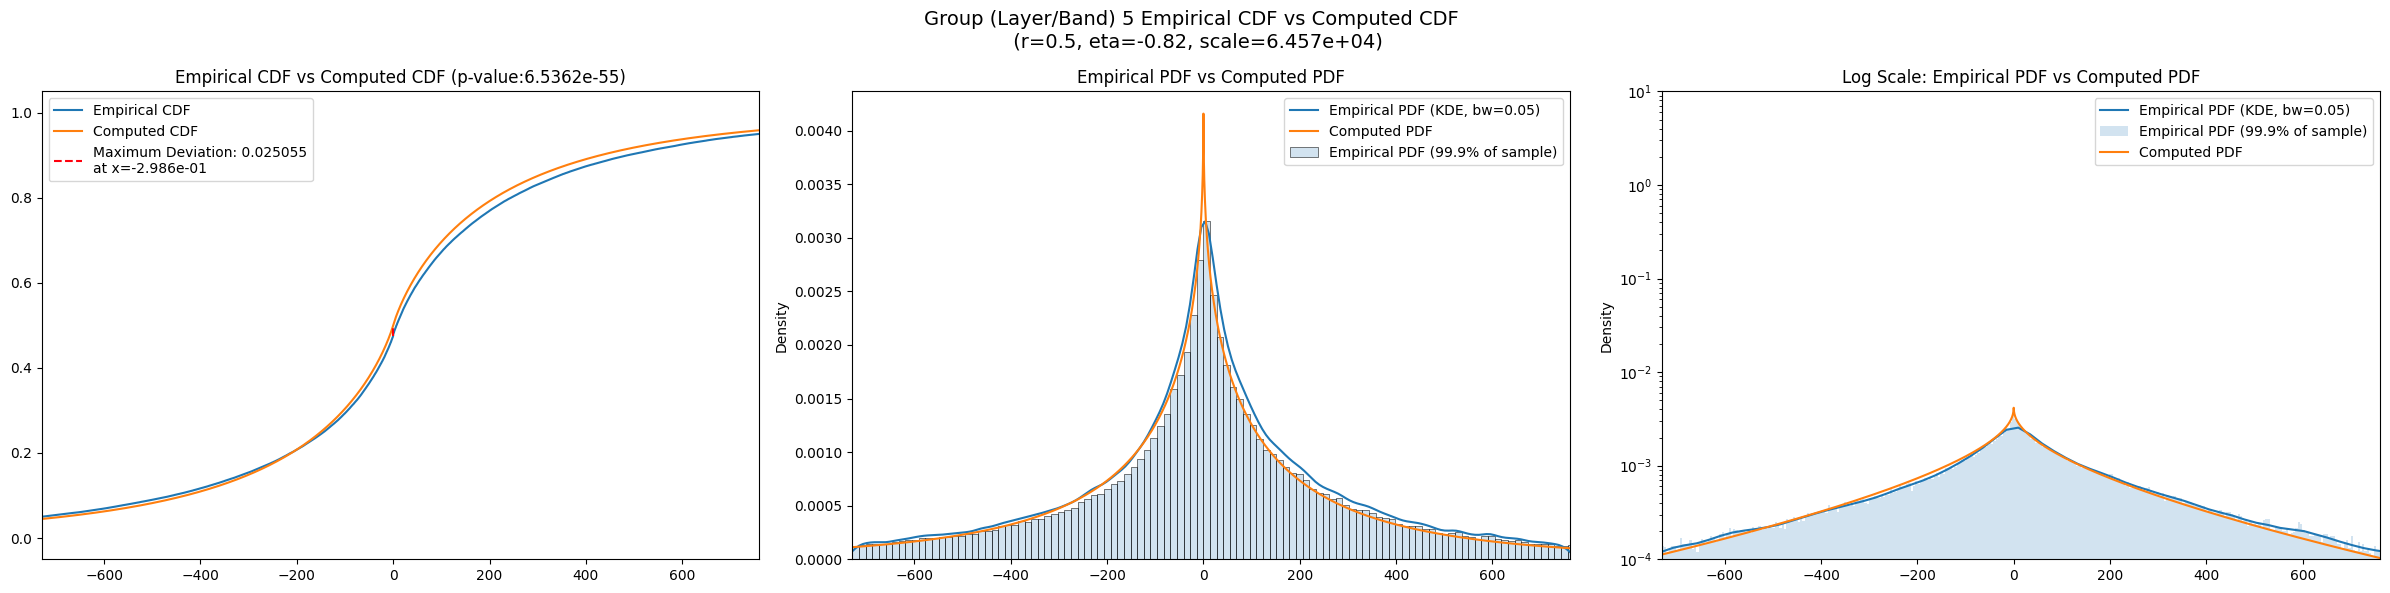

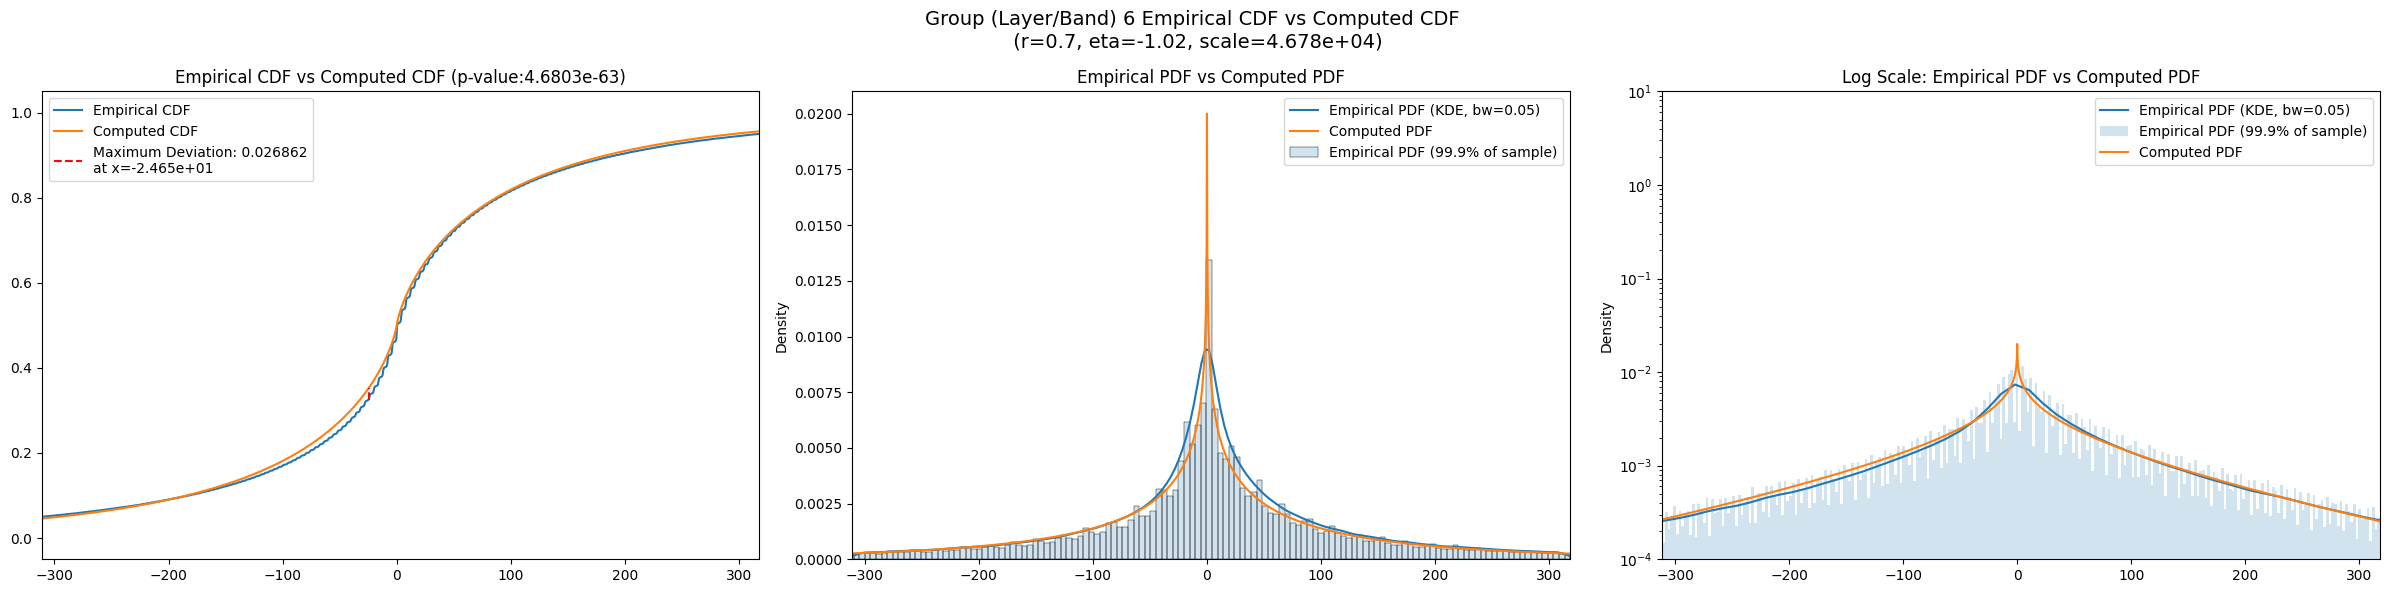

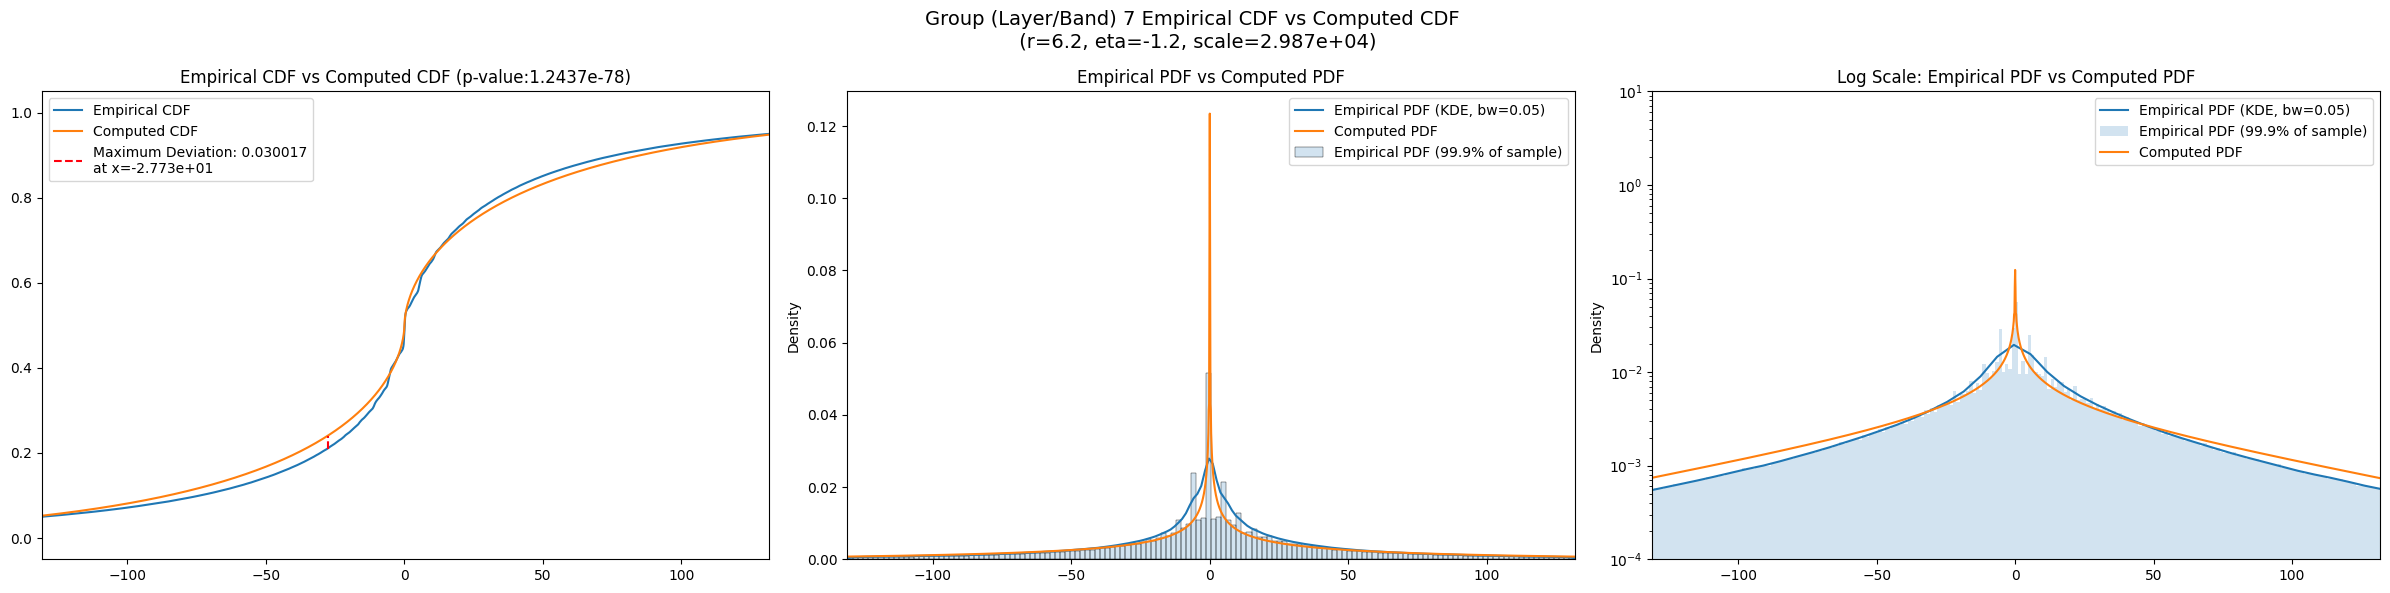

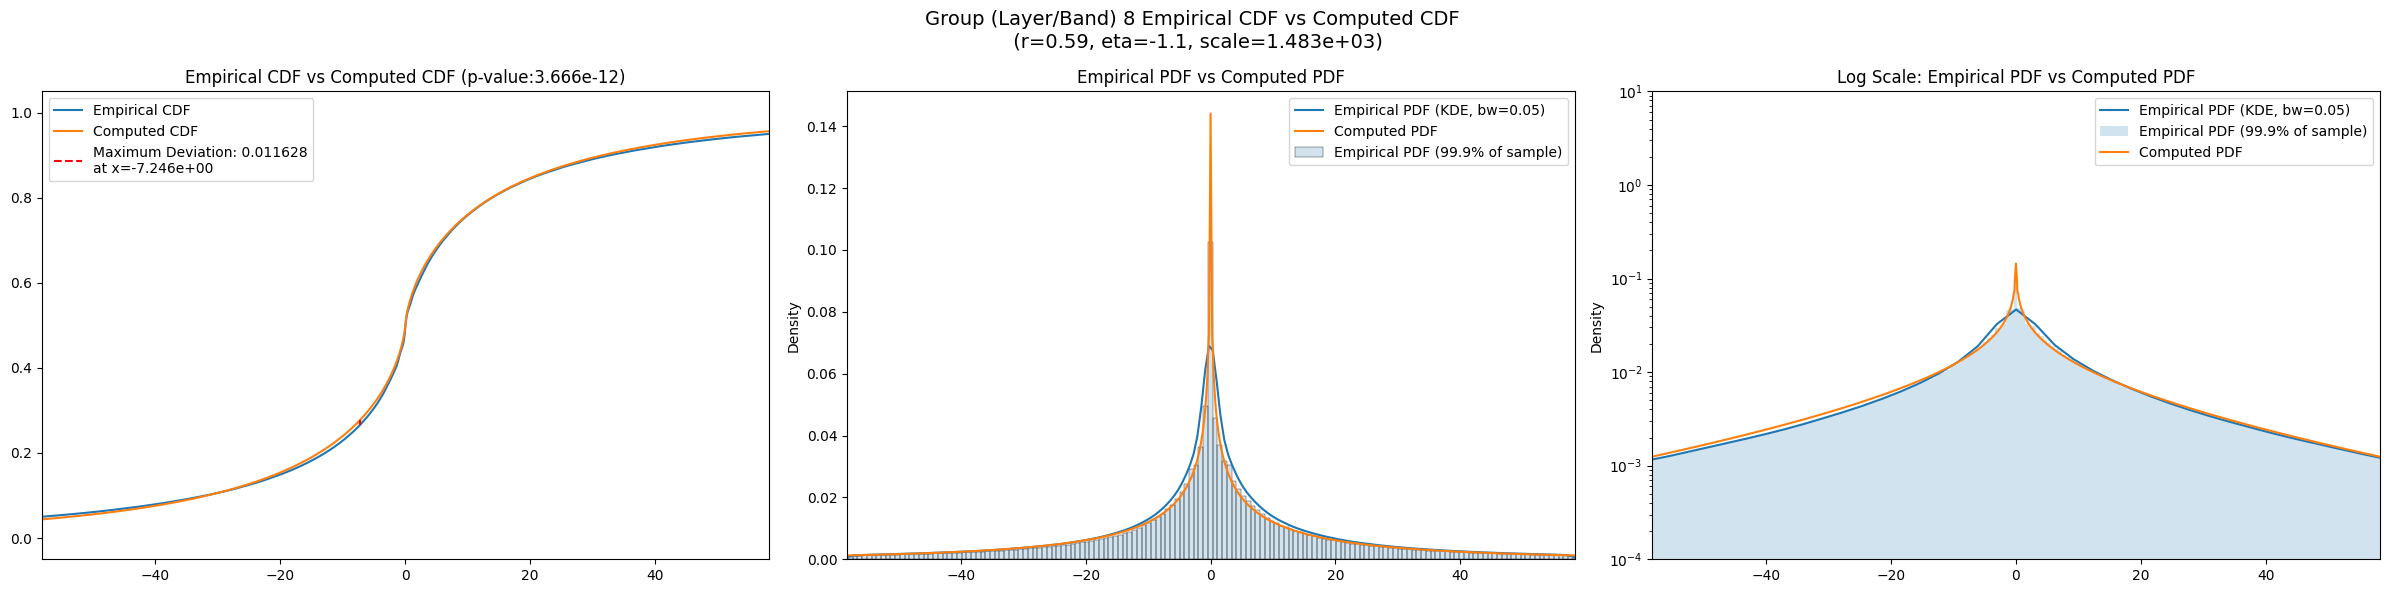

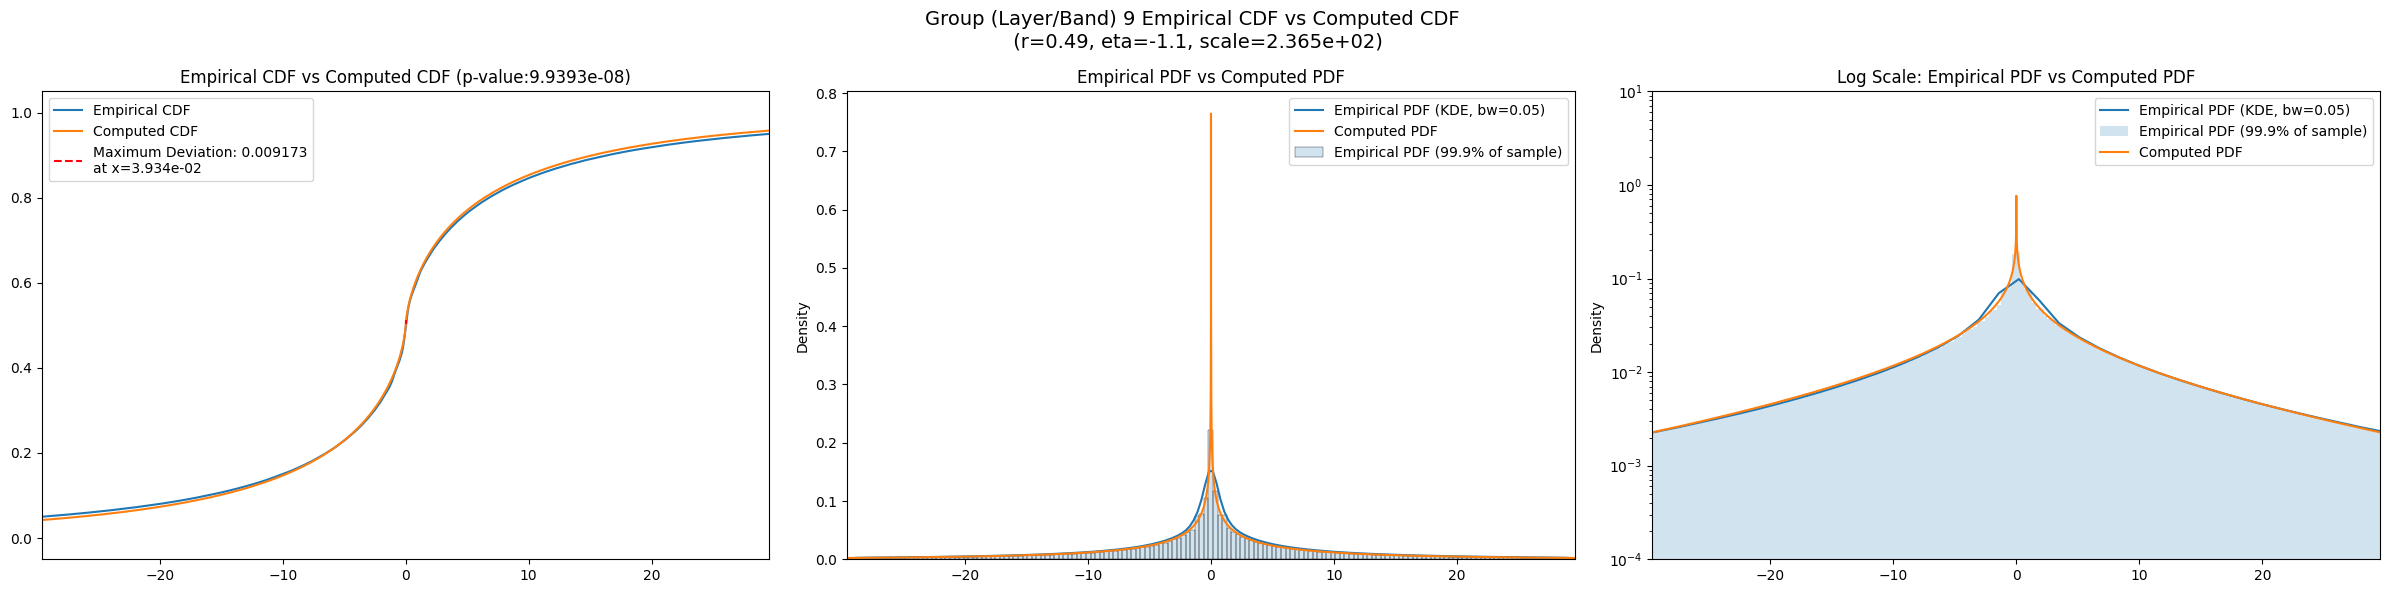

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005503e+07  2.753430e+07  3.270686e+07   0.729729    0.399138   
3      5.664364e+06  5.395078e+06  5.943322e+06   1.467379    1.230193   
4      1.100039e+06  1.039317e+06  1.162902e+06   2.750267    2.308960   
5      2.109552e+05  1.972024e+05  2.252086e+05   4.704251    4.043499   
6      4.082369e+04  3.770970e+04  4.410653e+04   7.281408    6.114861   
7      8.082411e+03  7.363835e+03  8.846996e+03  10.621169    8.625637   
8      1.791217e+03  1.613921e+03  1.979800e+03  13.649155   11.172685   
9      4.776345e+02  4.297178e+02  5.291696e+02  14.632936   11.962647   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.080607           2446             0.058424        0.2          7.2   
3        1.719118           9784             0.046430        0.4          0.8   
4        3.245013          39136             0.031987        0.4         -0.1   
5        5.443361         156544             0.025090        0.5         -0.8   
6        8.737075         626176             0.026878        0.6         -1.0   
7       13.356113        2504704             0.029739        6.2         -1.2   
8       16.721000       10018816             0.011749        0.6         -1.1   
9       17.944490       40075264             0.009218        0.5         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       4768.0000              0.063037          6.820900e-09   
3      ...       1857.7000              0.055648          8.935830e-27   
4      ...        738.7390              0.055413         6.815370e-105   
5      ...        269.8410              0.065915          0.000000e+00   
6      ...         98.4028              0.075797          0.000000e+00   
7      ...         38.1017              0.077676          0.000000e+00   
8      ...         16.5457              0.077091          0.000000e+00   
9      ...          8.0095              0.080304          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         4804.27000             0.062938         7.248090e-09  3911.05000   
3         1895.86000             0.046242         1.279950e-18  1404.63000   
4          633.35500             0.033058         1.361890e-37   530.49300   
5          232.04900             0.039734        3.444170e-215   188.01400   
6           84.12100             0.050298         0.000000e+00    67.26020   
7           32.09170             0.053960         0.000000e+00    25.37940   
8           14.22860             0.051585         0.000000e+00    11.13440   
9            6.76883             0.056520         0.000000e+00     5.28622   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.058335   1.120360e-07          1.064984e-07  
3           0.046609   6.572010e-19          9.360285e-19  
4           0.038456   1.006930e-50          5.049171e-34  
5           0.044500  8.026440e-270          1.066900e-85  
6           0.053878   0.000000e+00          0.000000e+00  
7           0.056612   0.000000e+00          0.000000e+00  
8           0.053213   0.000000e+00          0.000000e+00  
9           0.058401   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.058424                 0.027391          0.058424   
3                 0.046430                 0.013713          0.046415   
4                 0.031987                 0.006861          0.031431   
5                 0.025090                 0.003431          0.025040   
6                 0.026878                 0.001716          0.026797   
7                 0.029739                 0.000858          0.029739   
8                 0.011749                 0.000429          0.011406   
9                 0.009218                 0.000215          0.009182   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.063037             0.062938       0.058335  
3                  0.055648             0.046242       0.046609  
4                  0.055413             0.033058       0.038456  
5                  0.065915             0.039734       0.044500  
6                  0.075797             0.050298       0.053878  
7                  0.077676             0.053960       0.056612  
8                  0.077091             0.051585       0.053213  
9                  0.080304             0.056520       0.058401

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            3.005503e+07          0.058424    0.20      7.20      0.154493   
3            5.664364e+06          0.046415    0.38      0.90  32622.054278   
4            1.067045e+06          0.031431    0.46     -0.30  88292.649637   
5            2.072482e+05          0.025040    0.50     -0.82  64571.364033   
6            3.730791e+04          0.026797    0.70     -1.02  46775.563725   
7            6.479214e+03          0.029739    6.20     -1.20  29874.353033   
8            1.357025e+03          0.011406    0.59     -1.10   1483.493005   
9            3.631183e+02          0.009182    0.49     -1.10    236.490665   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                     25.0  
6                    125.0  
7                    300.0  
8                    325.0  
9                    300.0

In [21]:
eng.quit()